<a href="https://colab.research.google.com/github/rodrigoclira/mineracao-dados/blob/main/Selecao_de_Atributos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Seleção de Atributos

Usamos seleção de atributos para escolher aqueles que sejam úteis ao modelo. Atributos irrelevantes podem causar um efeito negativo. Atributos correlacionados podem deixar os coeficientes das regressões instáveis ou difícieis de interpretar. 

A **maldição da dimensionalidade** é outra questão a ser considerada. À medida que você aumenta o número de dimensões de seus dados, eles se tornarão mais esparsos. Isso pode dificultar a obtenção de um sinal, a menos que você tenha mais dados. Cálculos de vizinhanças tendem a perder a utilidade a medida que mais dimensões são adicionadas. 

Além disso, o tempo para treinamento dos dados em geral é uma função do número de colunas. Se você conseguir ser conciso e preciso com suas colunas, será possível obter um modelo melhor em menos tempo. Descrevendo alguns exemplos usando conjunto de dados. 

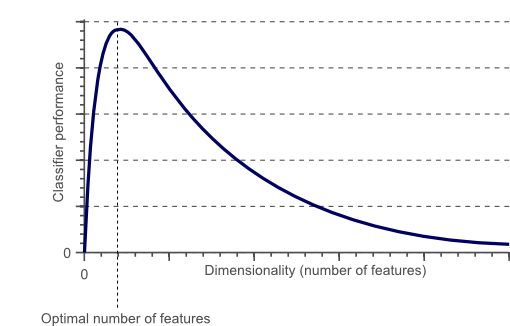

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.experimental import (
    enable_iterative_imputer,
)
from sklearn import (
    ensemble,
    impute,
    model_selection,    
    preprocessing,
    tree,
)

In [4]:
url = "https://github.com/rodrigoclira/mineracao-dados/blob/main/datasets/titanic3.xls?raw=true"
df = pd.read_excel(url)
orig_df = df

podemos agregar dados de cabine (idade máxima por cabine, idade média por cabine etc.). Para obter dados agregados por cabine, utilize o método .groupby do pandas para criá-los

In [5]:
df.groupby("cabin").agg("min,max,mean,sum".split(",")).reset_index()

/tmp/ipykernel_15176/3266433192.py:1: FutureWarning: ['name', 'sex', 'ticket', 'embarked', 'boat', 'home.dest'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df.groupby("cabin").agg("min,max,mean,sum".split(",")).reset_index()


cabin pclass              survived                age  ... parch      \
             min max mean sum      min max mean sum   min  ...  mean sum   
0     A10      1   1  1.0   1        0   0  0.0   0  36.0  ...   0.0   0   
1     A11      1   1  1.0   1        1   1  1.0   1  33.0  ...   0.0   0   
2     A14      1   1  1.0   1        0   0  0.0   0   NaN  ...   0.0   0   
3     A16      1   1  1.0   1        1   1  1.0   1  48.0  ...   0.0   0   
4     A18      1   1  1.0   1        0   0  0.0   0  39.0  ...   0.0   0   
..    ...    ...  ..  ...  ..      ...  ..  ...  ..   ...  ...   ...  ..   
181   F33      2   2  2.0   8        1   1  1.0   4  22.0  ...   0.0   0   
182   F38      3   3  3.0   3        0   0  0.0   0   NaN  ...   0.0   0   
183    F4      2   2  2.0   8        1   1  1.0   4   1.0  ...   1.5   6   
184    G6      3   3  3.0  15        0   1  0.6   3   1.0  ...   1.2   6   
185     T      1   1  1.0   1        0   0  0.0   0  45.0  ...   0.0   0   

        fare                               body                       
         min      max     mean       sum    min    max   mean    sum  
0    40.1250  40.1250  40.1250   40.1250    NaN    NaN    NaN    0.0  
1    27.7208  27.7208  27.7208   27.7208    NaN    NaN    NaN    0.0  
2    52.0000  52.0000  52.0000   52.0000    NaN    NaN    NaN    0.0  
3    39.6000  39.6000  39.6000   39.6000    NaN    NaN    NaN    0.0  
4    29.7000  29.7000  29.7000   29.7000  133.0  133.0  133.0  133.0  
..       ...      ...      ...       ...    ...    ...    ...    ...  
181  10.5000  13.0000  11.1250   44.5000    NaN    NaN    NaN    0.0  
182   7.7500   7.7500   7.7500    7.7500    NaN    NaN    NaN    0.0  
183  39.0000  39.0000  39.0000  156.0000    NaN    NaN    NaN    0.0  
184  10.4625  16.7000  14.2050   71.0250    NaN    NaN    NaN    0.0  
185  35.5000  35.5000  35.5000   35.5000    NaN    NaN    NaN    0.0  

[186 rows x 29 columns]

In [6]:
agg = (df.groupby("cabin")
     .agg("min,max,mean,sum".split(","))
     .reset_index())

agg.columns = [
     "_".join(c).strip("_")
     for c in agg.columns.values
]

agg_df = df.merge(agg, on="cabin")
agg_df

/tmp/ipykernel_15176/3758571985.py:2: FutureWarning: ['name', 'sex', 'ticket', 'embarked', 'boat', 'home.dest'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  .agg("min,max,mean,sum".split(","))


,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,...,parch_mean,parch_sum,fare_min,fare_max,fare_mean,fare_sum,body_min,body_max,body_mean,body_sum
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,...,0.5,1,211.3375,211.3375,211.3375,422.675,NaN,NaN,NaN,0.0
1,1,1,"Madill, Miss. Georgette Alexandra",female,15.0000,0,1,24160,211.3375,B5,...,0.5,1,211.3375,211.3375,211.3375,422.675,NaN,NaN,NaN,0.0
2,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,...,2.0,8,151.5500,151.5500,151.5500,606.200,135.0,135.0,135.0,135.0
3,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,...,2.0,8,151.5500,151.5500,151.5500,606.200,135.0,135.0,135.0,135.0
4,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,...,2.0,8,151.5500,151.5500,151.5500,606.200,135.0,135.0,135.0,135.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,3,1,"Sandstrom, Mrs. Hjalmar (Agnes Charlotta Bengt...",female,24.0000,0,2,PP 9549,16.7000,G6,...,1.2,6,10.4625,16.7000,14.2050,71.025,NaN,NaN,NaN,0.0
291,3,1,"Sandstrom, Miss. Marguerite Rut",female,4.0000,1,1,PP 9549,16.7000,G6,...,1.2,6,10.4625,16.7000,14.2050,71.025,NaN,NaN,NaN,0.0
292,3,0,"Strom, Miss. Telma Matilda",female,2.0000,0,1,347054,10.4625,G6,...,1.2,6,10.4625,16.7000,14.2050,71.025,NaN,NaN,NaN,0.0
293,3,0,"Strom, Mrs. Wilhelm (Elna Matilda Persson)",female,29.0000,1,1,347054,10.4625,G6,...,1.2,6,10.4625,16.7000,14.2050,71.025,NaN,NaN,NaN,0.0


In [7]:
def tweak_titanic(df):
    df = df.drop(
        columns=[
            "name",
            "ticket",
            "home.dest",
            "boat",
            "body",
            "cabin",
        ]
    ).pipe(pd.get_dummies, drop_first=True)
    return df

In [8]:

def get_train_test_X_y(df, y_col, size=0.3, std_cols=None):
    y = df[y_col]
    X = df.drop(columns=y_col)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=size, random_state=42
    )
    cols = X.columns
    num_cols = [
        "pclass",
        "age",
        "sibsp",
        "parch",
        "fare",
    ]
    fi = impute.IterativeImputer()
    fitted = fi.fit_transform(X_train[num_cols])
    X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(num_cols)})
    test_fit = fi.transform(X_test[num_cols])
    X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(num_cols)})
    if std_cols:
        std = preprocessing.StandardScaler()
        fitted = std.fit_transform(X_train[std_cols])
        X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(std_cols)})
        test_fit = std.transform(X_test[std_cols])
        X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(std_cols)})

    return X_train, X_test, y_train, y_test


In [9]:

ti_df = tweak_titanic(orig_df)
std_cols = "pclass,age,sibsp,fare".split(",")
X_train, X_test, y_train, y_test = get_train_test_X_y(
    ti_df, "survived", std_cols=std_cols
)

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

# Colunas colineares

Podemos executar o código a seguir para encontrar colunas que tenham um coeficiente de correlação maior ou igual a 0,95.

In [10]:
limit = 0.95 #correlação 

corr = agg_df.corr()
mask = np.triu(
    np.ones(corr.shape), k=1
).astype(bool)
corr_no_diag = corr.where(mask)
coll = [
    c
    for c in corr_no_diag.columns
    if any(abs(corr_no_diag[c]) > limit)
]
coll

['pclass_min',
 'pclass_max',
 'pclass_mean',
 'sibsp_mean',
 'parch_mean',
 'fare_mean',
 'body_min',
 'body_max',
 'body_mean',
 'body_sum']

O pacote rfpimp (https://oreil.ly/MsnXc) tem um recurso de visualização de
multicolinearidade. A função plot_dependence_heatmap faz o treinamento de uma
floresta aleatória (random forest) para cada coluna numérica a partir das
outras colunas em um conjunto de dados de treinamento. O valor da
dependência é a pontuação R2 das estimativas OOB (Out-Of-Bag) para a
predição dessa coluna

In [11]:
!pip install rfpimp

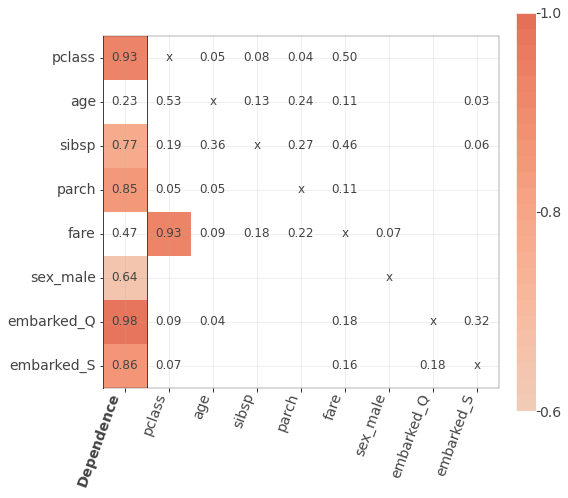

In [12]:
import rfpimp
rfpimp.plot_dependence_heatmap(
    rfpimp.feature_dependence_matrix(X_train),
    value_fontsize=12,
    label_fontsize=14,
    figsize=(8, 8)
)
fig = plt.gcf()

A forma sugerida de usar esse gráfico é encontrar valores próximos de 1. O 
rótulo no eixo X é o atributo que faz a predição do rótulo do eixo Y. Se um
atributo faz a predição de outro, podemos remover o atributo previsto (o
atributo no eixo Y). Em nosso exemplo, fare faz a predição de pclass, sibsp, parch e embarked_Q. Poderemos manter fare e remover os demais atributos, obtendo
um desempenho semelhante

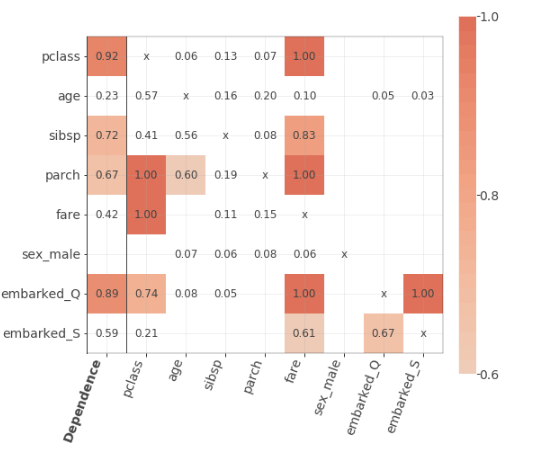

In [46]:
from sklearn.ensemble import RandomForestClassifier

cols_to_remove = [
    "pclass",
#    "sibsp",
#    "parch",
#    "embarked_Q",
]





rf3 = RandomForestClassifier(random_state=2)
rf3.fit(
    X_train[
        [
            c
            for c in X_train.columns
            if c not in cols_to_remove
        ]
    ],
    y_train,
)

RandomForestClassifier(random_state=2)

In [47]:

rf3.score(
    X_test[
        [
            c
            for c in X_train.columns
            if c not in cols_to_remove
        ]
    ],
    y_test,
)


0.8015267175572519

In [48]:
rf4 = RandomForestClassifier(random_state=2)
rf4.fit(X_train, y_train)
rf4.score(X_test, y_test)

0.8091603053435115

# Eliminação Recursiva de atributos

A eliminação recursiva de atributos removerá os atributos mais fracos, e
então fará a adequação de um modelo. Fazemos isso passando um modelo do scikit-learn com um atributo .coef_ ou .feature_importances_:

In [50]:
from yellowbrick.features import RFECV
rfe = RFECV(
    ensemble.RandomForestClassifier(
        n_estimators=100, random_state=20
    ),
    cv=5,
)

[1 1 1 2 1 1 4 3]
5
[ True  True  True False  True  True False False]


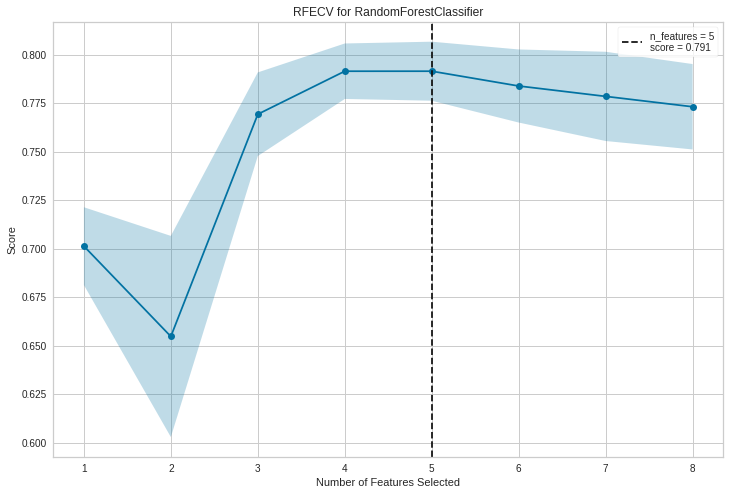

<AxesSubplot:title={'center':'RFECV for RandomForestClassifier'}, xlabel='Number of Features Selected', ylabel='Score'>

In [51]:
fig, ax = plt.subplots(figsize=(12, 8))

rfe.fit(X, y)
print(rfe.rfe_estimator_.ranking_)
print(rfe.rfe_estimator_.n_features_)
print(rfe.rfe_estimator_.support_)
rfe.poof()

Usaremos a eliminação recursiva de atributos para encontrar os cinco atributos
mais importantes.

In [17]:
from sklearn.feature_selection import RFE
model = ensemble.RandomForestClassifier(
    n_estimators=100
)
rfe = RFE(model, n_features_to_select = 5)
rfe.fit(X, y)
X.columns[rfe.support_]

Index(['pclass', 'age', 'sibsp', 'fare', 'sex_male'], dtype='object')

# Leitura Complementar

https://scikit-learn.org/stable/modules/feature_selection.html

https://towardsdatascience.com/5-feature-selection-method-from-scikit-learn-you-should-know-ed4d116e4172